---
author: Zeel B Patel
badges: true
categories: ML
description: Challenges in fitting to a combination of sine waves
output-file: 2023-04-29-sine-combination-netowrks.html
title: Sine Combination Networks
date: '2023-04-29'
toc: true
---

We know that any continuous signal can be represented as a sum of sinusoids. The question is, how many sinusoids do we need to represent a signal? In this notebook, we will explore this question.

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import jax
import jax.numpy as jnp
import optax

from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Random Combination of Sinusoids

(1000, 1) (1000, 1)


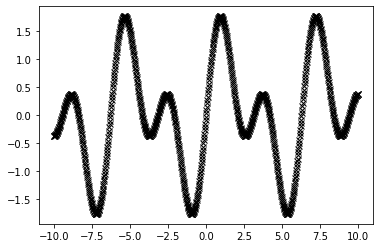

In [7]:
N = 1000
x = jnp.linspace(-10, 10, N).reshape(-1, 1)
y = jnp.sin(x) + jnp.sin(2*x) #+ jax.random.normal(jax.random.PRNGKey(0), (N, 1)) * 0.1
plt.plot(x, y, "kx");
print(x.shape, y.shape)

## Recover the Signal

In [8]:
def get_weights(key):
    w1 = jax.random.uniform(key, (), minval=0.0, maxval=5.0)
    key = jax.random.split(key)[0]
    w2 = jax.random.uniform(key, (), minval=0.0, maxval=5.0)
    return w1, w2
    
def get_sine(weights, x):
    w1, w2 = weights
    return jnp.sin(w1*x) + jnp.sin(w2*x)

def loss_fn(weights, x, y):
    output = get_sine(weights, x)
    w1, w2 = weights
    return jnp.mean((output.ravel() - y.ravel())**2)

100%|██████████| 12/12 [00:00<00:00, 15.91it/s]


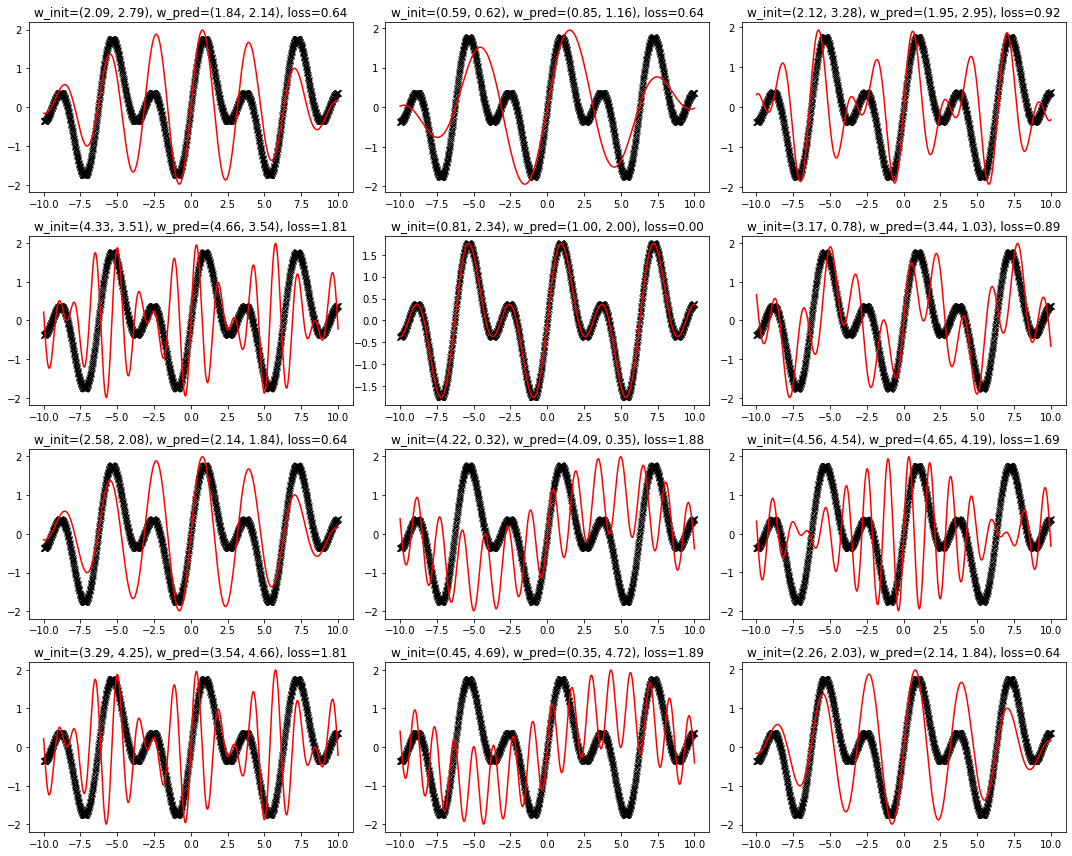

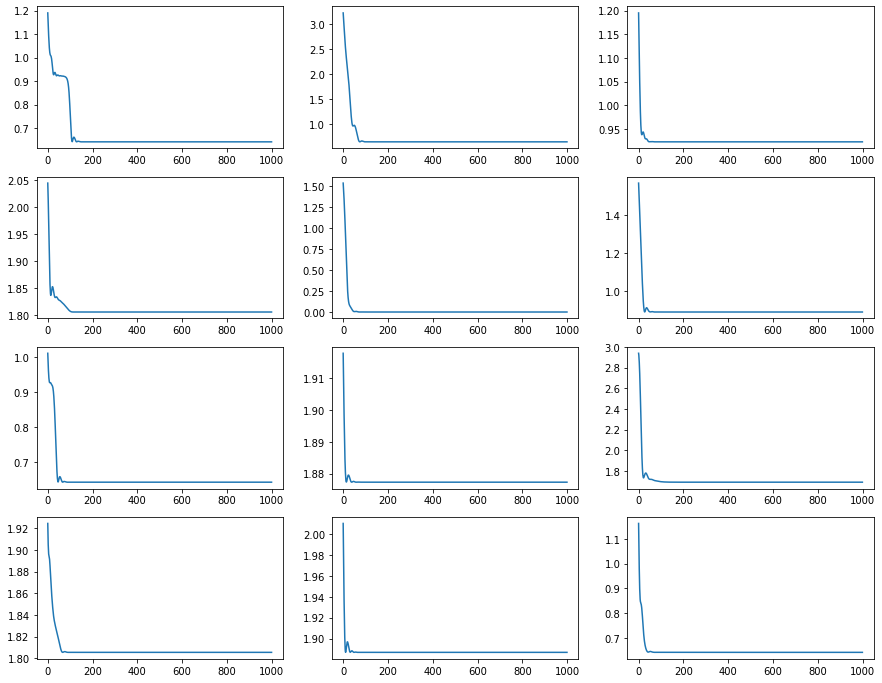

In [9]:
def one_step(weights_and_state, xs):
    weights, state = weights_and_state
    loss, grads = value_and_grad_fn(weights, x, y)
    updates, state = optimizer.update(grads, state)
    weights = optax.apply_updates(weights, updates)
    return (weights, state), (loss, weights)

epochs = 1000
optimizer = optax.adam(1e-2)
value_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn))
fig, ax = plt.subplots(4, 3, figsize=(15, 12))
fig2, ax2 = plt.subplots(4, 3, figsize=(15, 12))
ax = ax.ravel()
ax2 = ax2.ravel()
for seed in tqdm(range(12)):
    key = jax.random.PRNGKey(seed)
    init_weights = get_weights(key)
    state = optimizer.init(init_weights)
    (weights, _), (loss_history, _) = jax.lax.scan(one_step, (init_weights, state), None, length=epochs)
    y_pred = get_sine(weights, x)
    ax[seed].plot(x, y, "kx")
    ax[seed].plot(x, y_pred, "r-")
    ax[seed].set_title(f"w_init=({init_weights[0]:.2f}, {init_weights[1]:.2f}), w_pred=({weights[0]:.2f}, {weights[1]:.2f}), loss={loss_fn(weights, x, y):.2f}")
    ax2[seed].plot(loss_history)
fig.tight_layout()

## Plot loss surface

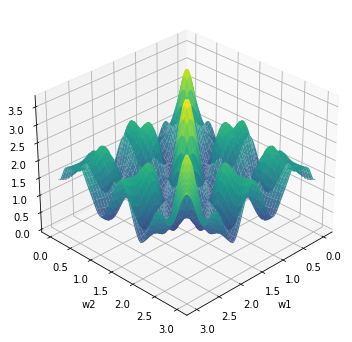

In [10]:
w1 = jnp.linspace(0, 3, 100)
w2 = jnp.linspace(0, 3, 100)
W1, W2 = jnp.meshgrid(w1, w2)
loss = jax.vmap(jax.vmap(lambda w1, w2: loss_fn((w1, w2), x, y)))(W1, W2)

# plot the loss surface in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W1, W2, loss, cmap="viridis", alpha=0.9);
ax.set_xlabel("w1");
ax.set_ylabel("w2");
# top view
ax.view_init(30, 45)